First, import some useful modules

In [22]:
%matplotlib notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
import re
import pylab

Now, load the training data set into a pandas data frame

In [3]:
training_df = pd.read_csv("train.csv")

Have a quick look at what's in the data - show first 5 rows only

In [4]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's extract first names, surnames and titles into additional columns. Note that we use regular expressions.

In [5]:
training_df["First_Name"] = training_df["Name"].apply(lambda _: _.split()[2])
training_df["Surname"] = training_df["Name"].apply(lambda _: _.split(",")[0])
training_df["Title"] = training_df["Name"].apply(lambda _: re.findall(",\s+(\w+)\.",_)[0] if len(re.findall(",\s+(\w+)\.",_)) > 0 else None)

Check that the columns have actually been added

In [7]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First_Name,Surname,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Owen,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,John,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Laina,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Jacques,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,William,Allen,Mr


In [9]:
sns.set(style="whitegrid")

Let's look at the age passengers split by sex

<IPython.core.display.Javascript object>


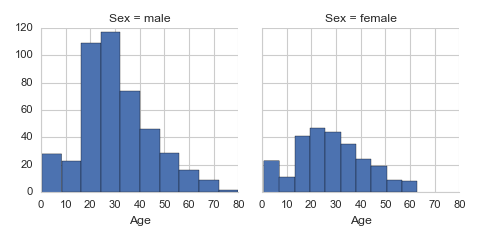

In [21]:
sns.FacetGrid(training_df, col="Sex").map(plt.hist, "Age")
pylab.show()

Apparently, there were more men than women on Titanic